In [1]:
import argparse
import csv
from collections import defaultdict, OrderedDict
import logging
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, spearmanr
import sys
import torch
from torch.nn.parallel import DistributedDataParallel as DDP

In [2]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))))
from dist_ir.importer import import_from_onnx, parse_tensor_from_file
from dist_ir.ir import FunctionMaker, cpprint, pformat, Device, Topology, Value
from dist_ir.executor import infer_types, SequentialExecutor, Simulator
from dist_ir.executor.cost_model import CostModel
from dist_ir.ir.type import Bool, Float, Int64, Tensor
from dist_ir.transforms import (
    mlp_dhp_transform,
    filter_transform,
    PipeDreamScheduler,
)
from examples.mlp import mlp

## PyTorch vs simulator

### Constants

In [3]:
DEVICE_THROUGHPUT = 1.38e13 # FLOPS
DRAM_BANDWIDTH = 7e11 # Bps
PCIE_BANDWIDTH = 77 # Gbps

### CSV utils

In [4]:
def parse_csv(filename):
    results = []
    with open(filename, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            results.append(
                (
                    row["world_size"],
                    row["num_hidden_layers"],
                    row["batch_size"],
                    row["hidden_dim"],
                    row["runtime"],
                )
            )
    return results

### PyTorch utils

In [5]:
def mlp_pytorch(num_hidden_layers, hidden_dim):
    layers = []
    for i in range(num_hidden_layers):
        layers.append(torch.nn.Linear(hidden_dim, hidden_dim, bias=False))
        layers.append(torch.nn.ReLU())
    return torch.nn.Sequential(*layers)

In [6]:
def setup(
    local_rank, world_size, backend="nccl", master_addr="localhost", master_port="12355"
):
    os.environ["MASTER_ADDR"] = master_addr
    os.environ["MASTER_PORT"] = master_port
    torch.distributed.init_process_group(
        backend, world_size=world_size, rank=local_rank
    )

In [7]:
def cleanup():
    torch.distributed.destroy_process_group()

### Experiment driver functions

In [8]:
def run(config):
    (
        local_rank,
        world_size,
        num_hidden_layers,
        batch_size,
        hidden_dim,
        num_warmup_steps,
        num_profiling_steps,
    ) = config
    model = mlp_pytorch(num_hidden_layers, hidden_dim).to(local_rank)
    loss_fn = torch.nn.MSELoss().to(local_rank)
    x = torch.randn(size=(batch_size // world_size, hidden_dim)).to(local_rank)
    labels = torch.randn(size=(batch_size // world_size, hidden_dim)).to(local_rank)
    if world_size > 1:
        setup(local_rank, world_size)
        model = DDP(model, device_ids=[local_rank], output_device=local_rank)
    runtimes = []
    torch.cuda.synchronize()
    events = [torch.cuda.Event(enable_timing=True)]
    events[0].record()
    for i in range(num_warmup_steps + num_profiling_steps):
        y = model(x)
        loss_fn(y, labels).backward()
        if world_size > 1:
            torch.distributed.barrier()
        events.append(torch.cuda.Event(enable_timing=True))
        events[-1].record()
    torch.cuda.synchronize()
    if world_size > 1:
        cleanup()
    runtimes = [events[i].elapsed_time(events[i+1]) / 1e3 for i in range(len(events)-1)]
    return np.median(runtimes[num_warmup_steps:])

In [9]:
def distributed_driver(num_hidden_layers, batch_size, hidden_dim, world_size):
    configs = [
        (rank, world_size, num_hidden_layers, batch_size, hidden_dim, 10, 100)
        for rank in range(world_size)
    ]
    with torch.multiprocessing.Pool(world_size) as p:
        results = p.map(run, configs)
    print(
        f"world_size={world_size}, "
        f"num_hidden_layers={num_hidden_layers}, "
        f"batch_size={batch_size}, "
        f"hidden_dim={hidden_dim}, "
        f"runtime={np.mean(results)}"
    )
    return np.mean(results)

In [10]:
def simulate(num_hidden_layers, batch_size, hidden_dim, world_size):
    topology = Topology()
    d0 = topology.add_device(
        "gpu", throughput=DEVICE_THROUGHPUT, dram_bandwidth=DRAM_BANDWIDTH
    )
    for i in range(world_size):
        di = topology.add_device(
            "gpu", throughput=DEVICE_THROUGHPUT, dram_bandwidth=DRAM_BANDWIDTH
        )
        topology.set_bandwidth(d0, di, float("inf"))
        for j in range(1, i + 1):
            dj = topology.devices[j]
            topology.set_bandwidth(di, dj, PCIE_BANDWIDTH)
    function = mlp(
        batch_size, hidden_dim, hidden_dim, hidden_dim, num_hidden_layers, d0
    )
    function = infer_types(function, function.inputs)
    if world_size > 1:
        dp_function = mlp_dhp_transform(function, world_size, 1, 1, topology.devices, 1)
        dp_function = infer_types(dp_function, dp_function.inputs)
    else:
        dp_function = function
    simulator = Simulator(CostModel(topology))
    simulation = simulator.interpret(
        dp_function,
        (v.type for v in dp_function.inputs),
    )
    return max([simulation.timestamps[d] for d in simulation.timestamps])

In [11]:
def sweep(
    all_world_sizes, all_num_hidden_layers, all_batch_sizes, all_hidden_dims, filename, func
):
    fieldnames = ["world_size", "num_hidden_layers", "batch_size", "hidden_dim", "runtime"]
    with open(filename, "w") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for world_size in all_world_sizes:
            for num_hidden_layers in all_num_hidden_layers:
                for batch_size in all_batch_sizes:
                    for hidden_dim in all_hidden_dims:
                        runtime = func(
                            num_hidden_layers, batch_size, hidden_dim, world_size
                        )
                        writer.writerow(
                            {
                                "world_size": world_size,
                                "num_hidden_layers": num_hidden_layers,
                                "batch_size": batch_size,
                                "hidden_dim": hidden_dim,
                                "runtime": runtime,
                            }
                        )

### Figure 3

In [12]:
all_world_sizes = [1, 2, 4]
all_num_hidden_layers = [8, 16, 32]
all_batch_sizes = [2048, 4096, 8192]
all_hidden_dims = [512, 1024, 2048]
sweep(
    all_world_sizes,
    all_num_hidden_layers,
    all_batch_sizes,
    all_hidden_dims,
    "data_parallel_runtimes.csv",
    distributed_driver,
)
sweep(
    all_world_sizes,
    all_num_hidden_layers,
    all_batch_sizes,
    all_hidden_dims,
    "data_parallel_simulated_runtimes.csv",
    simulate,
)

In [13]:
real_results = parse_csv("data_parallel_runtimes.csv")
simulated_results = parse_csv("data_parallel_simulated_runtimes.csv")

In [14]:
real_throughputs = defaultdict(list)
simulated_throughputs = defaultdict(list)
rtest = defaultdict(lambda: defaultdict(int))
stest = defaultdict(lambda: defaultdict(int))
print(f"world_size,# layers,batch size,hidden dim,model size (MB),real,simulated,ratio")
for real, simulated in zip(real_results, simulated_results):
    world_size = int(real[0])
    num_hidden_layers = int(real[1])
    batch_size = int(real[2])
    hidden_dim = int(real[3])
    real_runtime = float(real[4])
    simulated_runtime = float(simulated[4])
    model_size = hidden_dim * hidden_dim * num_hidden_layers * 4 / (1024 * 1024)
    print(
        f"{world_size},{num_hidden_layers},{batch_size},{hidden_dim},"
        f"{model_size},{real_runtime*1000:.2f},"
        f"{simulated_runtime*1000:.2f},"
        f"{(simulated_runtime/real_runtime):.2f}x"
    )
    real_throughputs[world_size].append(batch_size / real_runtime / 1000)
    simulated_throughputs[world_size].append(batch_size / simulated_runtime / 1000)

world_size,# layers,batch size,hidden dim,model size (MB),real,simulated,ratio
1,8,2048,512,8.0,3.74,2.09,0.56x
1,8,2048,1024,32.0,9.24,7.96,0.86x
1,8,2048,2048,128.0,33.39,31.05,0.93x
1,8,4096,512,8.0,5.33,4.15,0.78x
1,8,4096,1024,32.0,17.85,15.82,0.89x
1,8,4096,2048,128.0,69.00,61.72,0.89x
1,8,8192,512,8.0,9.55,8.28,0.87x
1,8,8192,1024,32.0,34.16,31.55,0.92x
1,8,8192,2048,128.0,127.63,123.05,0.96x
1,16,2048,512,16.0,6.39,4.18,0.65x
1,16,2048,1024,64.0,18.72,15.92,0.85x
1,16,2048,2048,256.0,67.92,62.10,0.91x
1,16,4096,512,16.0,10.71,8.31,0.78x
1,16,4096,1024,64.0,36.20,31.65,0.87x
1,16,4096,2048,256.0,140.71,123.43,0.88x
1,16,8192,512,16.0,19.21,16.56,0.86x
1,16,8192,1024,64.0,69.25,63.10,0.91x
1,16,8192,2048,256.0,259.61,246.09,0.95x
1,32,2048,512,32.0,11.69,8.35,0.71x
1,32,2048,1024,128.0,37.61,31.84,0.85x
1,32,2048,2048,512.0,136.93,124.19,0.91x
1,32,4096,512,32.0,21.51,16.61,0.77x
1,32,4096,1024,128.0,72.70,63.29,0.87x
1,32,4096,2048,512.0,283.89,246.85,0.87x
1,32,8192,512,32.0,38

Pearson's correlation: 0.9273070306956839 (p=1.8542583290905386e-35)
Spearman's correlation: 0.9336946702800362 (p=5.549420399611977e-37)


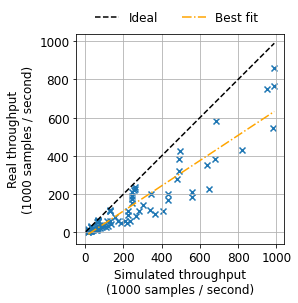

In [15]:
plt.rcParams["font.size"] = 12
all_simulated_throughputs = []
all_real_throughputs = []
lines = []
labels = ["Ideal", "Best fit"]
for world_size in simulated_throughputs:
    all_real_throughputs += real_throughputs[world_size]
for world_size in simulated_throughputs:
    all_simulated_throughputs += simulated_throughputs[world_size]
all_simulated_throughputs = np.array(all_simulated_throughputs)
all_real_throughputs = np.array(all_real_throughputs)
r, p = pearsonr(all_simulated_throughputs, all_real_throughputs)
print(f"Pearson's correlation: {r} (p={p})")
r, p = spearmanr(all_simulated_throughputs, all_real_throughputs)
print(f"Spearman's correlation: {r} (p={p})")
x_new = np.linspace(min(all_simulated_throughputs.min(), all_real_throughputs.min()),
                    max(all_simulated_throughputs.max(), all_real_throughputs.max()),
                    500)
lines.append(plt.plot(x_new, x_new, color="black", linestyle="--", label="Ideal")[0])
m, b = np.polyfit(all_simulated_throughputs, all_real_throughputs, 1)
f = interp1d(all_simulated_throughputs, m * all_simulated_throughputs + b, kind="linear")
x_new = np.linspace(all_simulated_throughputs.min(),
                    all_simulated_throughputs.max(),
                    500)
y_smooth = f(x_new)
lines.append(plt.plot(x_new, y_smooth, color="orange", linestyle="-.", label="Best fit")[0])
colors = ["b", "orange", "g", "purple"]
markers = ['x', 'o', '^'] 
plt.scatter(all_simulated_throughputs, all_real_throughputs, marker='x')
plt.grid()
plt.xticks([0, 200, 400, 600, 800, 1000])
plt.yticks([0, 200, 400, 600, 800, 1000])
plt.xlabel("Simulated throughput\n(1000 samples / second)")
plt.ylabel("Real throughput\n(1000 samples / second)")
plt.gca().set_aspect('equal', adjustable='box')
leg = plt.figlegend(lines, labels, loc="upper center", ncol=2)
leg.get_frame().set_linewidth(0.0)
bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())
yOffset = 0
bb.y0 += yOffset
bb.y1 += yOffset
leg.set_bbox_to_anchor(bb, transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig("data_parallel_simulation_performance.pdf", dpi=600, bbox_inches="tight")

## Isolated parallelism simulation results

### Constants

In [16]:
DGX_BANDWIDTH_GBPS = 4800

### Utils

In [17]:
def add_devices_to_topology(topology, num_devices):
    for i in range(num_devices):
        topology.add_device("gpu")
    devices = topology.devices
    for i in range(0, len(devices)):
        for j in range(i+1, len(devices)):
            topology.set_bandwidth(devices[i], devices[j], DGX_BANDWIDTH_GBPS)
    return topology

### Data parallelism

In [18]:
all_num_devices = [2, 4, 8, 16, 32]
all_batch_sizes = [512, 1024, 2048, 4096]
input_dim = 4096
hidden_dim = input_dim
output_dim = hidden_dim
num_hidden_layers = 64
dp_results = defaultdict(list)
for batch_size in all_batch_sizes:
    topology = Topology()
    d0 = topology.add_device("gpu")
    function = mlp(batch_size, input_dim, hidden_dim, output_dim, num_hidden_layers, d0)
    function = infer_types(function, function.inputs)
    simulator = Simulator(CostModel(topology))
    simulation = simulator.interpret(
        function,
        (v.type for v in function.inputs),
    )
    sequential_running_time = max(
        [simulation.timestamps[d] for d in simulation.timestamps]
    )
    for i, num_devices in enumerate(all_num_devices):
        if i == 0:
            add_devices_to_topology(topology, num_devices)
        else:
            add_devices_to_topology(
                topology, all_num_devices[i] - all_num_devices[i - 1]
            )
        assert len(topology.devices) == all_num_devices[i] + 1
        simulator = Simulator(CostModel(topology))
        transformed_function = mlp_dhp_transform(
            function,
            num_devices,
            1,
            1,
            topology.devices,
            1,
        )
        transformed_function = infer_types(
            transformed_function, transformed_function.inputs
        )
        transformed_function, typed_input_values = filter_transform(
            transformed_function, filter_set=set(["MPIBroadcast", "Send"])
        )
        transformed_function = infer_types(transformed_function, typed_input_values)
        simulation = simulator.interpret(
            transformed_function,
            (v.type for v in transformed_function.inputs),
        )
        distributed_running_time = max(
            [simulation.timestamps[d] for d in simulation.timestamps]
        )
        speedup = sequential_running_time / distributed_running_time
        dp_results[batch_size].append(speedup)

### Pipeline parallelism

In [19]:
all_num_devices = [2, 4, 8, 16, 32]
all_num_microbatches = [4, 8, 16, 32]
input_dim = 4096
hidden_dim = input_dim
output_dim = hidden_dim
num_hidden_layers = 64
batch_size = 4096
pp_results = defaultdict(list)
topology = Topology()
d0 = topology.add_device("gpu")
function = mlp(batch_size, input_dim, hidden_dim, output_dim, num_hidden_layers, d0)
function = infer_types(function, function.inputs)
simulator = Simulator(CostModel(topology))
simulation = simulator.interpret(
    function,
    (v.type for v in function.inputs),
)
sequential_running_time = max([simulation.timestamps[d] for d in simulation.timestamps])
for i, num_microbatches in enumerate(all_num_microbatches):
    topology = Topology()
    d0 = topology.add_device("gpu")
    for j, num_devices in enumerate(all_num_devices):
        if j == 0:
            add_devices_to_topology(topology, num_devices)
        else:
            add_devices_to_topology(
                topology, all_num_devices[j] - all_num_devices[j - 1]
            )
        assert len(topology.devices) == all_num_devices[j] + 1
        simulator = Simulator(CostModel(topology))
        transformed_function = mlp_dhp_transform(
            function,
            1,
            1,
            num_devices,
            topology.devices,
            num_microbatches,
        )
        transformed_function = infer_types(
            transformed_function, transformed_function.inputs
        )
        transformed_function, typed_input_values = filter_transform(
            transformed_function,
            filter_set=set(["Send"]),
            exception_set=set(transformed_function.inputs[:2]),
        )
        transformed_function = infer_types(transformed_function, typed_input_values)
        simulation = simulator.interpret(
            transformed_function,
            (v.type for v in transformed_function.inputs),
        )
        distributed_running_time = max(
            [simulation.timestamps[d] for d in simulation.timestamps]
        )
        speedup = sequential_running_time / distributed_running_time
        pp_results[num_microbatches].append(speedup)

### Figure 4

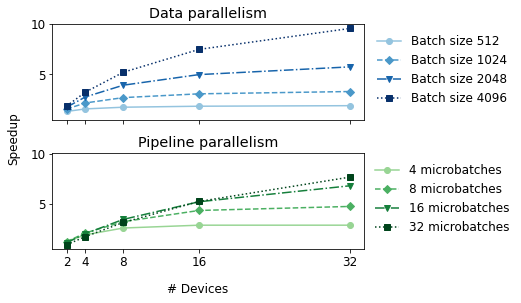

In [20]:
plt.rcParams["font.size"] = 12
fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True, sharey=True)
markers = ["o", "D", "v", "s", "<", "x"]
styles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1, 1, 1))]
c = np.arange(1, len(pp_results) + 3)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
dp_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
dp_cmap.set_array([])
pp_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
pp_cmap.set_array([])
dp_lines = []
dp_labels = []
for i, batch_size in enumerate(dp_results):
    dp_labels.append(f"Batch size {batch_size}")
    l = axes[0].plot(
        all_num_devices,
        dp_results[batch_size],
        marker=markers[i],
        linestyle=styles[i],
        label=dp_labels[-1],
        c=dp_cmap.to_rgba(i + 3),
    )[0]
    dp_lines.append(l)
    plt.xticks([2, 4, 8, 16, 32])
    plt.yticks([5, 10, 15, 20])
pp_lines = []
pp_labels = []
for i, num_microbatches in enumerate(pp_results):
    pp_labels.append(f"{num_microbatches} microbatches")
    l = axes[1].plot(
        all_num_devices,
        pp_results[num_microbatches],
        marker=markers[i],
        label=pp_labels[-1],
        linestyle=styles[i],
        c=pp_cmap.to_rgba(i + 3)
    )[0]
    pp_lines.append(l)
axes[0].set_title("Data parallelism")
axes[1].set_title("Pipeline parallelism")
fig.text(0.5, -.025, '# Devices', ha='center', va='center')
fig.text(-.01, 0.5, 'Speedup', va='center', ha='center', rotation='vertical')
fig.tight_layout()
dp_leg = axes[0].legend(dp_lines, dp_labels, loc='upper center', ncol=1)
dp_leg.get_frame().set_linewidth(0.0)
# Get the bounding box of the original legend.
bb = dp_leg.get_bbox_to_anchor().transformed(axes[0].transAxes.inverted())

# Change to location of the legend. 
xOffset = 0.75
bb.x0 += xOffset
bb.x1 += xOffset
dp_leg.set_bbox_to_anchor(bb, transform = axes[0].transAxes)

pp_leg = axes[1].legend(pp_lines, pp_labels, loc='upper center', ncol=1)
pp_leg.get_frame().set_linewidth(0.0)
# Get the bounding box of the original legend.
bb = pp_leg.get_bbox_to_anchor().transformed(axes[1].transAxes.inverted())

# Change to location of the legend. 
bb.x0 += xOffset
bb.x1 += xOffset
pp_leg.set_bbox_to_anchor(bb, transform = axes[1].transAxes)
plt.savefig("dp_and_pp.pdf", dpi=600, bbox_inches="tight")

## Grid search simulation results

In [21]:
# TODO: Re-generate data in notebook
# Columns are: dp_degree / hp_degree / pp_degree / num_microbatches / throughput
data = pd.read_csv(
    "euromlsys21_grid_search_results.csv",
    names=["D", "H", "P", "num_microbatches", "throughput"],
    header=0,
)

### Figure 5

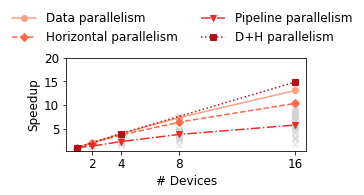

In [22]:
plt.rcParams["font.size"] = 12
data["speedup"] = data["throughput"] / 3725.917956
only_D = [r["speedup"] for i, r in data.iterrows() if r["H"] == 1 and r["P"] == 1]
only_H = [r["speedup"] for i, r in data.iterrows() if r["D"] == 1 and r["P"] == 1]
half_DH = [r["speedup"] for i, r in data.iterrows() if r["D"] == r["H"] and r["P"] == 1]
half_DH_devs = [
    r["D"] * r["H"] * r["P"]
    for i, r in data.iterrows()
    if r["D"] == r["H"] and r["P"] == 1
]
# For each P degree, find the num_microbatches with best throughput (note it's not always 32!)
pp_data = data[(data["D"] == 1) & (data["H"] == 1)]
best_P = pp_data.loc[pp_data.groupby("P")["throughput"].idxmax()]

devices = [2 ** i for i in range(5)]
colors = []
markers = ["o", "D", "v", "s", "<", "x"]
styles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1, 1, 1))]
c = np.arange(1, len(only_D) + 3)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap.set_array([])
plt.figure(figsize=(4, 2))
lines = []
labels = [
    "Data parallelism",
    "Horizontal parallelism",
    "Pipeline parallelism",
    "D+H parallelism",
]
lines.append(
    plt.plot(
        devices,
        only_D,
        marker=markers[0],
        linestyle=styles[0],
        c=cmap.to_rgba(0 + 3),
        label=labels[0],
    )[0]
)
lines.append(
    plt.plot(
        devices,
        only_H,
        marker=markers[1],
        linestyle=styles[1],
        c=cmap.to_rgba(1 + 3),
        label=labels[1],
    )[0]
)
lines.append(
    plt.plot(
        best_P["P"],
        best_P["speedup"],
        marker=markers[2],
        linestyle=styles[2],
        c=cmap.to_rgba(2 + 3),
        label=labels[2],
    )[0]
)
lines.append(
    plt.plot(
        half_DH_devs,
        half_DH,
        marker=markers[3],
        linestyle=styles[3],
        c=cmap.to_rgba(3 + 3),
        label=labels[3],
    )[0]
)
plt.scatter(
    data["D"] * data["H"] * data["P"],
    data["speedup"],
    marker="x",
    color="lightgray",
    alpha=0.5,
)
# plt.grid(True)
plt.yticks([5, 10, 15, 20])
plt.xticks([2, 4, 8, 16])
leg = plt.figlegend(lines, labels, loc="upper center", ncol=2)
leg.get_frame().set_linewidth(0.0)
# Get the bounding box of the original legend.
bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())

# Change to location of the legend.
yOffset = 0.45
bb.y0 += yOffset
bb.y1 += yOffset
leg.set_bbox_to_anchor(bb, transform=plt.gca().transAxes)
plt.tight_layout()
plt.tight_layout()
plt.xlabel("# Devices")
plt.ylabel("Speedup")
plt.savefig("grid_search.pdf", dpi=600, bbox_inches="tight")